In [1]:
#! pip -q install pandas matplotlib
#! pip install -q scikit-learn
#! pip install -q joblib
#! pip install -q tensorflow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

train_df_raw = pd.read_csv("data/train.csv")
train_calendar_df_raw = pd.read_csv("data/train_calendar.csv")
test_df_raw = pd.read_csv("data/test.csv")
test_calendar_df_raw = pd.read_csv("data/test_calendar.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])
train_calendar_df_raw['date'] = pd.to_datetime(train_calendar_df_raw['date'])
test_df_raw['date'] = pd.to_datetime(test_df_raw['date'])
test_calendar_df_raw['date'] = pd.to_datetime(test_calendar_df_raw['date'])

### Optional Dataset Validation

Evaluate the data correctness. Check both .csvs if their values in the same columns match and then merge them into one dataset.

In [3]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nSuccess. All values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [4]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df_merged = merge_csv(train_df_raw, train_calendar_df_raw)
test_df_merged = merge_csv(test_df_raw, test_calendar_df_raw) 

{'snow', 'mov_change', 'shutdown', 'shops_closed', 'holiday_name', 'holiday', 'blackout', 'winter_school_holidays', 'frankfurt_shutdown', 'date', 'warehouse', 'mini_shutdown', 'school_holidays', 'precipitation'}
No differences found in column: snow
No differences found in column: mov_change
No differences found in column: shutdown
No differences found in column: shops_closed
No differences found in column: holiday_name
No differences found in column: holiday
No differences found in column: blackout
No differences found in column: winter_school_holidays
No differences found in column: frankfurt_shutdown
No differences found in column: mini_shutdown
No differences found in column: school_holidays
No differences found in column: precipitation

Success. All values match across the datasets, datasets merged.
{'shops_closed', 'holiday_name', 'holiday', 'winter_school_holidays', 'date', 'warehouse', 'school_holidays'}
No differences found in column: shops_closed
No differences found in column

In [5]:
train_df = train_df_merged.sort_values(by=['date', 'warehouse'])
test_df = test_df_merged.sort_values(by=['date', 'warehouse'])

### Drop unnecesary data

There are some data in the training set that will not be availiable in the testing / inference data inputs.

In [6]:
# get features that are not available in the test dataset
unavailable_features = list(set(train_df.columns).difference(set(test_df.columns)))    
unavailable_features.remove('orders')

print(f"Common features: {unavailable_features}")

Common features: ['snow', 'mov_change', 'user_activity_2', 'user_activity_1', 'shutdown', 'blackout', 'frankfurt_shutdown', 'mini_shutdown', 'warehouse_limited', 'precipitation']


In [7]:
train_df = train_df.drop(columns=unavailable_features)

In [8]:
# list redundant columns that have unchanging values
unchanging_columns = []
for column in train_df.columns:
    if train_df[column].nunique() == 1:
        unchanging_columns.append(column)
print(unchanging_columns)

train_df = train_df.drop(columns=unchanging_columns)

[]


In [9]:
# find out if there are changing values in column "school_holiday"
print(train_df['winter_school_holidays'].value_counts())

winter_school_holidays
0    7120
1     220
Name: count, dtype: int64


In [10]:
print(train_df.columns)
print(f"train data: {train_df.shape}")
print(f"test data: {test_df.shape}")

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')
train data: (7340, 9)
test data: (397, 8)


In [11]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

warehouse                    0
date                         0
orders                       0
holiday_name              7122
holiday                      0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
id                           0
dtype: int64
warehouse                   0
date                        0
holiday_name              380
holiday                     0
shops_closed                0
winter_school_holidays      0
school_holidays             0
id                          0
dtype: int64


In [12]:
test_df.head()

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
61,Brno_1,2024-03-16,NaN,0,0,0,0,Brno_1_2024-03-16
340,Budapest_1,2024-03-16,NaN,0,0,0,0,Budapest_1_2024-03-16
292,Frankfurt_1,2024-03-16,NaN,0,0,0,0,Frankfurt_1_2024-03-16
244,Munich_1,2024-03-16,NaN,0,0,0,0,Munich_1_2024-03-16
0,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16


In [13]:
# What is the gap between the date of the last training data and the first test data?
train_max_date = train_df['date'].max()
test_min_date = test_df['date'].min()
print(f"Train max date: {train_max_date}")
print(f"Test min date: {test_min_date}")
print(f"Gap: {test_min_date - train_max_date}")

Train max date: 2024-03-15 00:00:00
Test min date: 2024-03-16 00:00:00
Gap: 1 days 00:00:00


In [14]:
train_df.columns

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')

In [15]:
# merge the two datasets to facilitate data preprocessing and lag features generation   
train_df = pd.concat([train_df, test_df], axis=0)

In [16]:
train_df = train_df.sort_values(by=['date', 'warehouse'])

In [17]:
# only get data with "warehouse == Prague_1"  for the dataset
train_df = train_df[train_df['warehouse'] == 'Prague_1']


In [18]:
train_df.head(10)

,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,Prague_1_2020-12-07
3,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,Prague_1_2020-12-08
4,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,Prague_1_2020-12-09
5,Prague_1,2020-12-10,7228.0,NaN,0,0,0,0,Prague_1_2020-12-10
6,Prague_1,2020-12-11,7790.0,NaN,0,0,0,0,Prague_1_2020-12-11
7,Prague_1,2020-12-12,7165.0,NaN,0,0,0,0,Prague_1_2020-12-12
8,Prague_1,2020-12-13,6844.0,NaN,0,0,0,0,Prague_1_2020-12-13
9,Prague_1,2020-12-14,7010.0,NaN,0,0,0,0,Prague_1_2020-12-14


In [19]:
# merge school_holiday and winter_schoolholiday into a single feature
#train_df['school_holiday'] = train_df['school_holidays'] | train_df['winter_school_holidays']
#train_df = train_df.drop(columns=['school_holidays', 'winter_school_holidays'])

In [20]:
from math import pi

def process_date(df):
    df.index = df.pop('date')
    
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df['days_since_start'] = (df.index - df.index.min()).days
    
    df['year_sin'] = df['year'] * np.sin(2 * pi * df['year'])
    df['year_cos'] = df['year'] * np.cos(2 * pi * df['year'])
    df['month_sin'] = df['month'] * np.sin(2 * pi * df['month'])
    df['month_cos'] = df['month'] * np.cos(2 * pi * df['month'])
    #df['day_sin'] = df['day'] * np.sin(2 * pi * df['day'])
    #df['day_cos'] = df['day'] * np.cos(2 * pi * df['day'])
    
    time_features = ['day', 'days_since_start', 'month', 'day_of_year', 'year_sin', 'year_cos', 'month_sin', 'month_cos']
    categorical_features = ['day_of_week', 'quarter', 'year'] 
    return df, time_features, categorical_features

### Features categories:
- time_features
- numerical_features
- categorical_features

In [21]:
train_df, time_features, categorical_features=process_date(train_df)

In [22]:
train_df['holiday_name'].fillna('noholiday', inplace=True)

In [23]:
train_df = train_df.drop(columns=['holiday_name']) 

### Plot

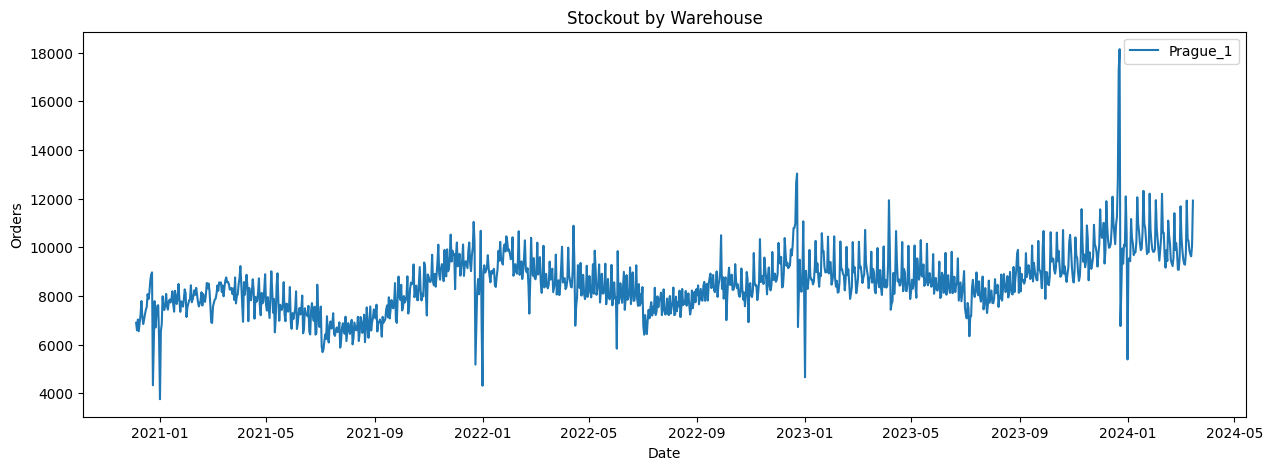

In [24]:
# Visualise the data
plt.figure(figsize=(15, 5))
for warehouse in train_df['warehouse'].unique():
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    plt.plot(warehouse_df.index, warehouse_df['orders'], label=warehouse)
plt.title("Stockout by Warehouse")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.show()

In [25]:
train_df['orders'].describe()

count     1193.000000
mean      8535.336966
std       1215.982528
min       3754.000000
25%       7812.000000
50%       8462.000000
75%       9174.000000
max      18139.000000
Name: orders, dtype: float64

<Axes: title={'center': 'Distribution'}, xlabel='Orders', ylabel='Frequency'>

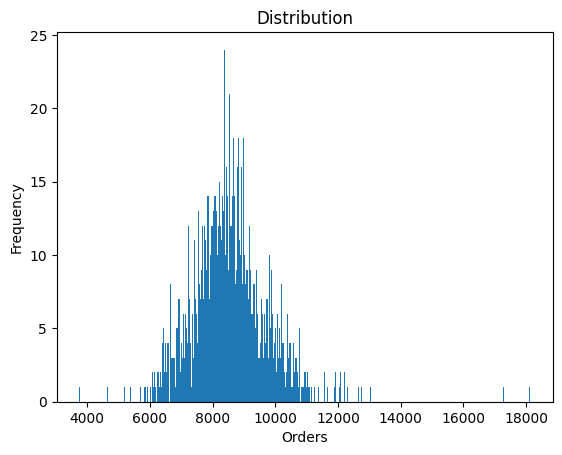

In [26]:
train_df['orders'].plot(kind='hist', bins=500, title='Distribution', xlabel='Orders')

<Axes: xlabel='date'>

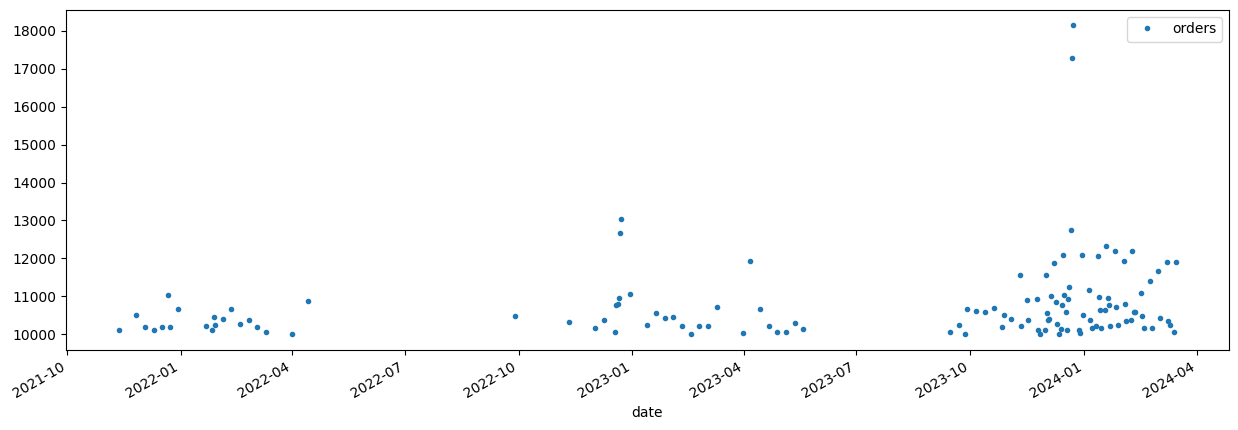

In [27]:
train_df.query('orders > 10000').plot(y='orders', figsize=(15, 5), style='.')

In [28]:

Q1 = train_df['orders'].quantile(0.25)
Q3 = train_df['orders'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 2.1 * IQR


iqr_outliers = train_df[(train_df['orders'] < lower_bound) | (train_df['orders'] > upper_bound)]

# Print number of outliers identified by each method
print(f"Number of IQR outliers: {iqr_outliers.shape[0]}")

iqr_outliers.head()


Number of IQR outliers: 18


,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,
2020-12-24,Prague_1,4327.0,1,0,0,0,Prague_1_2020-12-24,4,2020,12,24,3,359,0,19,-1.630940e-09,2020.0,-3.526983e-14,12.0
2021-01-01,Prague_1,3754.0,1,1,0,0,Prague_1_2021-01-01,1,2021,1,1,4,1,0,27,-2.967562e-10,2021.0,-2.449294e-16,1.0
2021-07-04,Prague_1,5689.0,0,0,0,0,Prague_1_2021-07-04,3,2021,7,4,6,185,1,211,-2.967562e-10,2021.0,-1.200154e-14,7.0
2021-12-24,Prague_1,5176.0,1,0,0,0,Prague_1_2021-12-24,4,2021,12,24,4,358,0,384,-2.967562e-10,2021.0,-3.526983e-14,12.0
2022-01-01,Prague_1,4309.0,1,1,0,0,Prague_1_2022-01-01,1,2022,1,1,5,1,1,392,-2.639248e-09,2022.0,-2.449294e-16,1.0


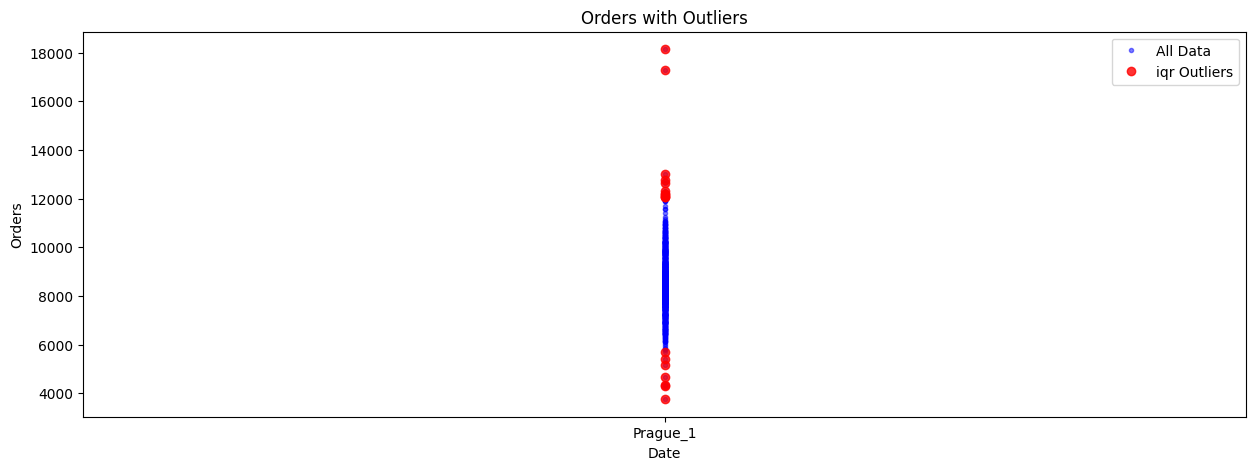

In [29]:
# Plot all data points
plt.figure(figsize=(15, 5))
plt.plot(train_df.warehouse, train_df['orders'], 'b.', alpha=0.5, label='All Data')

# Highlight outliers
plt.plot(iqr_outliers.warehouse, iqr_outliers['orders'], 'ro', alpha=0.8, label='iqr Outliers')


# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Orders with Outliers')
plt.legend()
plt.show()

In [30]:
# Drop outliers
#train_df = train_df.drop(iqr_outliers.index)

# Do not drop outliers but fix their values to be average

train_df.loc[iqr_outliers.index, 'orders'] = train_df['orders'].mean()

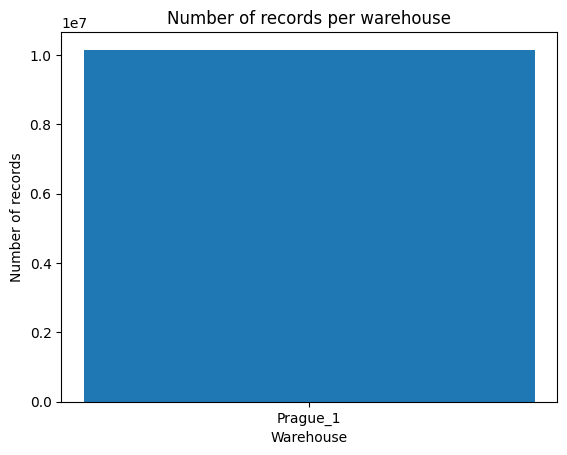

In [31]:
whs = train_df.groupby('warehouse')['orders'].sum()

plt.bar(whs.index, whs.values)
plt.xlabel('Warehouse')
plt.ylabel('Number of records')
plt.title('Number of records per warehouse')
plt.show()

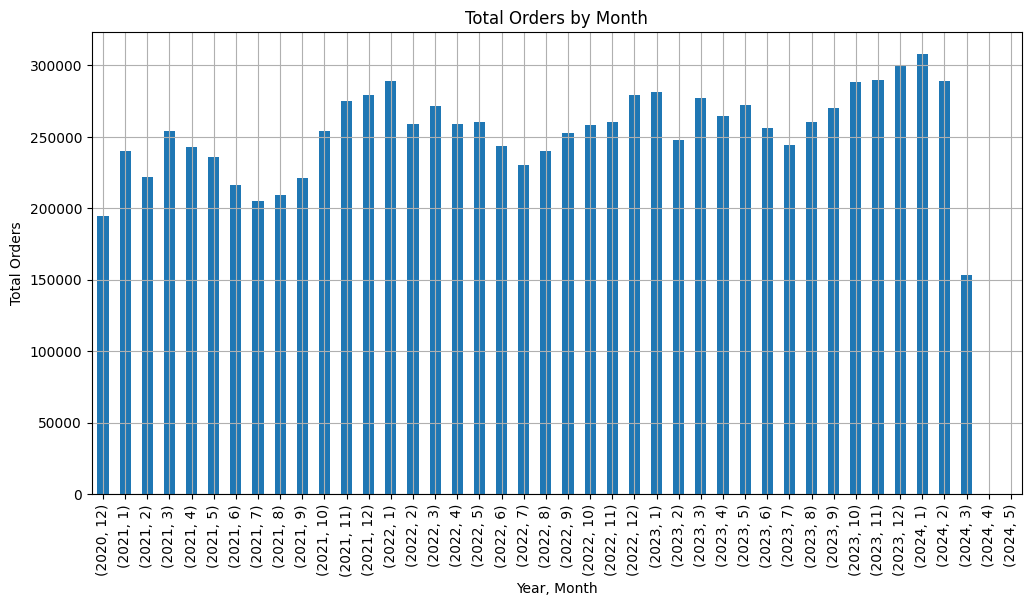

In [32]:
# plot the orders
df_by_month = train_df.groupby(['year', 'month'])['orders'].sum()
df_by_month.plot(kind='bar', figsize=(12, 6))

plt.title('Total Orders by Month')
plt.ylabel('Total Orders')
plt.xlabel('Year, Month')
plt.xticks(np.arange(len(df_by_month)), df_by_month.index, rotation=90)
plt.grid(True)
plt.show()

In [33]:
# remove the 3. month of the 2024 of the dataset
latest_date = train_df.index.max()
first_of_last_month = latest_date.replace(day=1)
# Filter out the rows from the last month
#train_df = train_df[train_df.index < first_of_last_month]

train_df.tail()

,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,
2024-05-11,Prague_1,NaN,0,0,0,0,Prague_1_2024-05-11,2,2024,5,11,5,132,1,1253,3.208798e-11,2024.0,-6.123234e-15,5.0
2024-05-12,Prague_1,NaN,0,0,0,0,Prague_1_2024-05-12,2,2024,5,12,6,133,1,1254,3.208798e-11,2024.0,-6.123234e-15,5.0
2024-05-13,Prague_1,NaN,0,0,0,0,Prague_1_2024-05-13,2,2024,5,13,0,134,0,1255,3.208798e-11,2024.0,-6.123234e-15,5.0
2024-05-14,Prague_1,NaN,0,0,0,0,Prague_1_2024-05-14,2,2024,5,14,1,135,0,1256,3.208798e-11,2024.0,-6.123234e-15,5.0
2024-05-15,Prague_1,NaN,0,0,0,0,Prague_1_2024-05-15,2,2024,5,15,2,136,0,1257,3.208798e-11,2024.0,-6.123234e-15,5.0


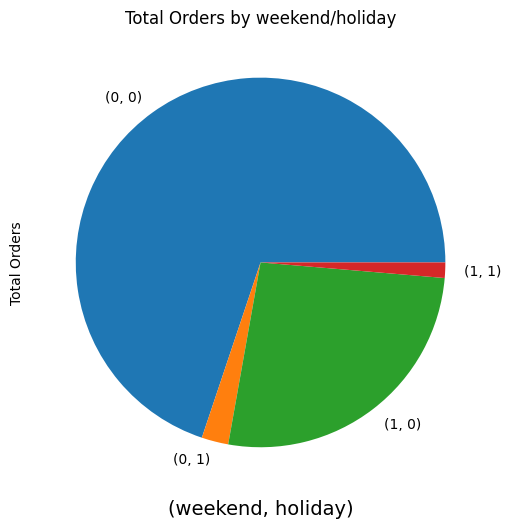

In [34]:
# plot the orders
df_by_month = train_df.groupby(['is_weekend', 'holiday'])['orders'].sum()
df_by_month.plot(kind='pie', figsize=(12, 6))

plt.title('Total Orders by weekend/holiday')
plt.ylabel('Total Orders')
plt.xlabel('(weekend, holiday)', fontdict={'fontsize': 14})
plt.show()

#### Compare feature Colerations

In [35]:
#train_df_corr = train_df.drop(columns=['warehouse', "id", 'holiday_name']).corr()
train_df_corr = train_df.drop(columns=['warehouse', "id"]).corr()

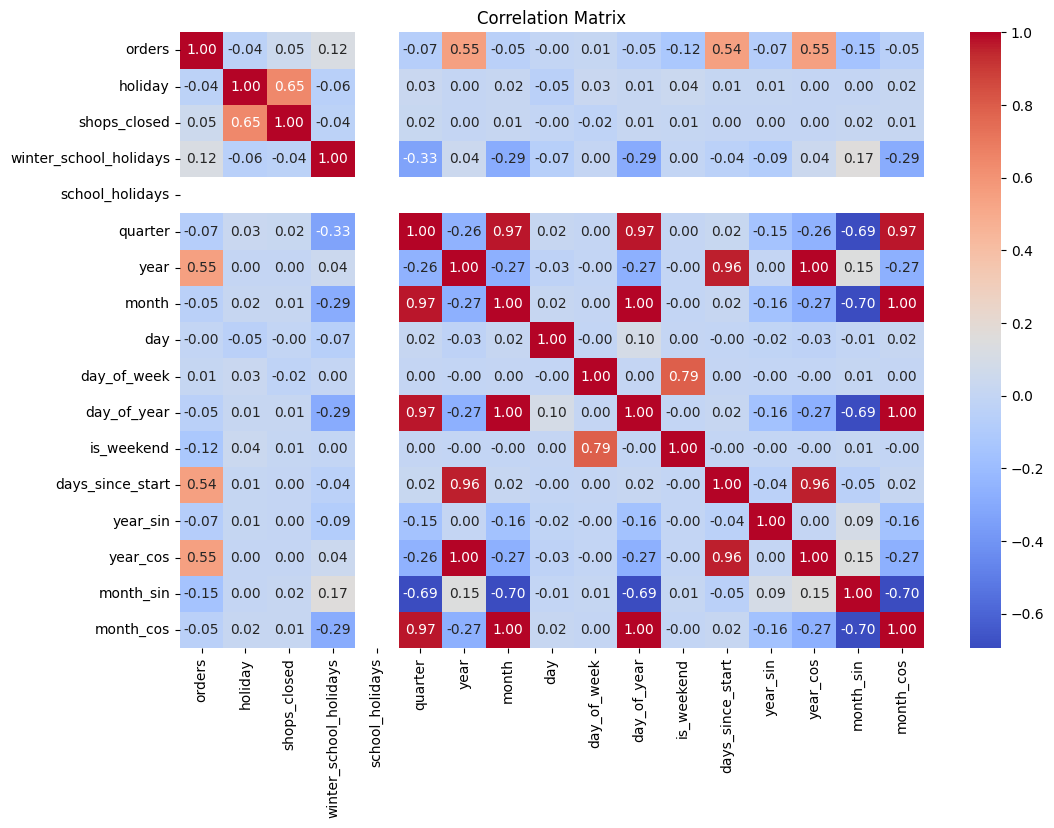

orders                    1.000000
year                      0.545799
year_cos                  0.545799
days_since_start          0.543938
winter_school_holidays    0.123639
shops_closed              0.048775
day_of_week               0.009712
day                      -0.000076
holiday                  -0.035906
day_of_year              -0.050622
month                    -0.052684
month_cos                -0.052684
quarter                  -0.070764
year_sin                 -0.074969
is_weekend               -0.123224
month_sin                -0.154679
school_holidays                NaN
Name: orders, dtype: float64


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation with 'orders'
print(train_df_corr['orders'].sort_values(ascending=False))

### Remove Outliers

#### Time Series Cross Validation



In [37]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=398, gap=1) # gap - 24house between train gata end - test data start
cross_val_train_df = train_df.sort_index()

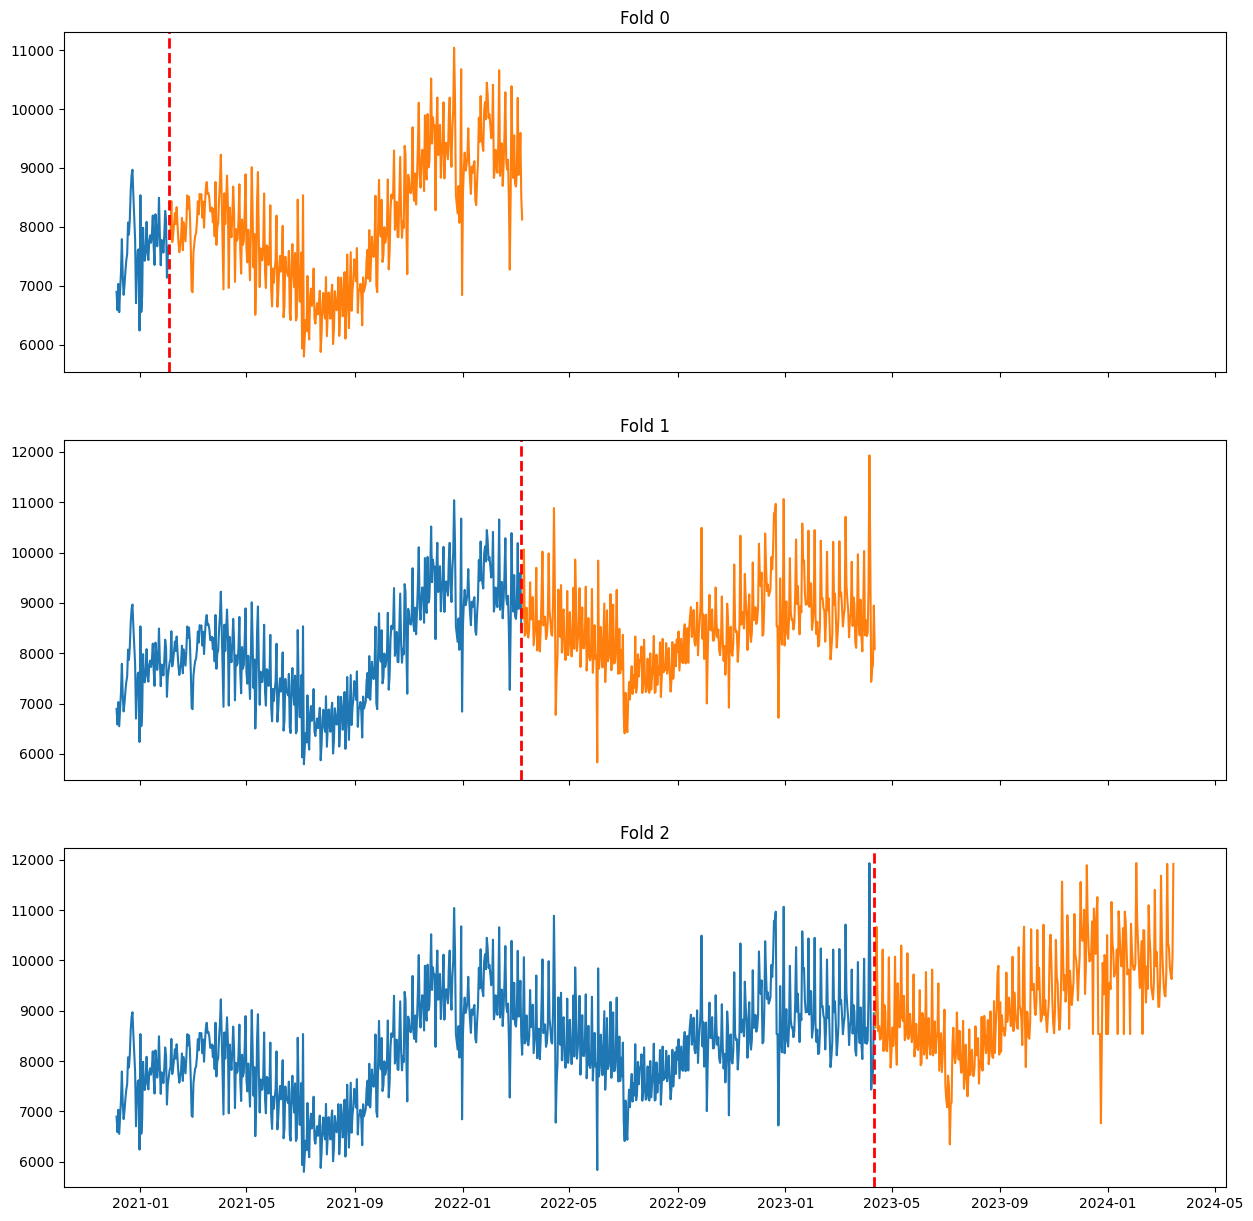

In [38]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, test_idx in tss.split(cross_val_train_df):
    train = cross_val_train_df.iloc[train_idx]
    test = cross_val_train_df.iloc[test_idx]
    
    ax[fold].plot(train.index, train['orders'], label='Train')
    ax[fold].plot(test.index, test['orders'], label='Test')
    ax[fold].set_title(f"Fold {fold}")
    ax[fold].axvline(train.index[-1], color='r', linestyle='--', lw=2)
    
    fold += 1

plt.show()

### Temporal features

In [39]:
train_df.head()

,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,
2020-12-05,Prague_1,6895.0,0,0,0,0,Prague_1_2020-12-05,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0
2020-12-06,Prague_1,6584.0,0,0,0,0,Prague_1_2020-12-06,4,2020,12,6,6,341,1,1,-1.630940e-09,2020.0,-3.526983e-14,12.0
2020-12-07,Prague_1,7030.0,0,0,0,0,Prague_1_2020-12-07,4,2020,12,7,0,342,0,2,-1.630940e-09,2020.0,-3.526983e-14,12.0
2020-12-08,Prague_1,6550.0,0,0,0,0,Prague_1_2020-12-08,4,2020,12,8,1,343,0,3,-1.630940e-09,2020.0,-3.526983e-14,12.0
2020-12-09,Prague_1,6910.0,0,0,0,0,Prague_1_2020-12-09,4,2020,12,9,2,344,0,4,-1.630940e-09,2020.0,-3.526983e-14,12.0


In [40]:
LAG_DAYS = [28, 56, 168, 364]
ROLLING_WINDOW = [28, 168, 364]

In [41]:
# Create lag features
def create_lag_features(df, col, lag_days):
    lag_features = []
    # create lag features for each warehouse, stop at the last dataset day even if the lag is not complete
    for lag in lag_days:
        df[f'{col}_lag_{lag}'] = df.groupby('warehouse')[col].shift(lag)
        lag_features.append(f'{col}_lag_{lag}')
    return df, lag_features


# Create rolling statistics
def create_rolling_features(df, col, windows):
    window_features = []
    # create rolling features for each warehouse, stop at the last dataset day even if the lag is not complete
    for window in windows:
        df[f'{col}_rolling_mean_{window}'] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[f'{col}_rolling_std_{window}'] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).std())
        window_features.extend([f'{col}_rolling_mean_{window}', f'{col}_rolling_std_{window}'])
    return df, window_features


In [42]:
# Apply the functions
train_df, lag_features = create_lag_features(train_df, 'orders', LAG_DAYS)
train_df, window_features = create_rolling_features(train_df, 'orders', ROLLING_WINDOW)

# Combine the features for easier visualization
numerical_features = ['orders']
numerical_features += lag_features + window_features
#categorical_features=categorical_features + ['warehouse', 'holiday_name']
categorical_features=categorical_features + ['warehouse']

print(numerical_features)

train_df.head()

['orders', 'orders_lag_28', 'orders_lag_56', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_28', 'orders_rolling_std_28', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']


,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,Prague_1,6895.0,0,0,0,0,Prague_1_2020-12-05,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0,NaN,NaN,NaN,NaN,6895.000000,NaN,6895.000000,NaN,6895.000000,NaN
2020-12-06,Prague_1,6584.0,0,0,0,0,Prague_1_2020-12-06,4,2020,12,6,6,341,1,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,NaN,NaN,NaN,NaN,6739.500000,219.910209,6739.500000,219.910209,6739.500000,219.910209
2020-12-07,Prague_1,7030.0,0,0,0,0,Prague_1_2020-12-07,4,2020,12,7,0,342,0,2,-1.630940e-09,2020.0,-3.526983e-14,12.0,NaN,NaN,NaN,NaN,6836.333333,228.714524,6836.333333,228.714524,6836.333333,228.714524
2020-12-08,Prague_1,6550.0,0,0,0,0,Prague_1_2020-12-08,4,2020,12,8,1,343,0,3,-1.630940e-09,2020.0,-3.526983e-14,12.0,NaN,NaN,NaN,NaN,6764.750000,235.308840,6764.750000,235.308840,6764.750000,235.308840
2020-12-09,Prague_1,6910.0,0,0,0,0,Prague_1_2020-12-09,4,2020,12,9,2,344,0,4,-1.630940e-09,2020.0,-3.526983e-14,12.0,NaN,NaN,NaN,NaN,6793.800000,213.885951,6793.800000,213.885951,6793.800000,213.885951


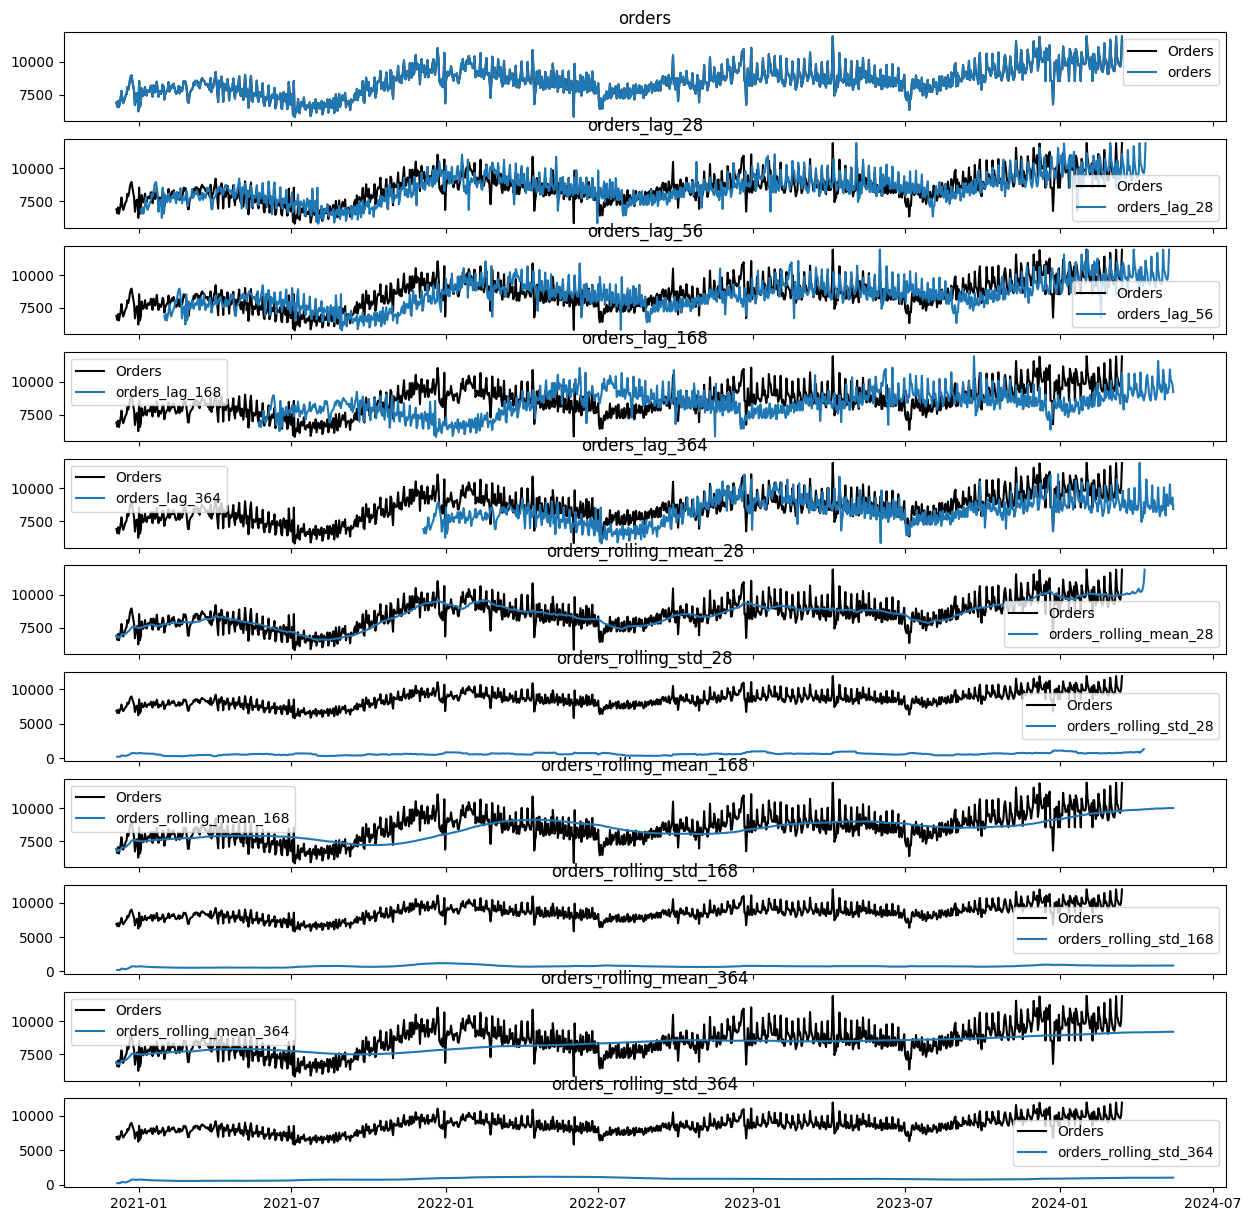

In [43]:
#orders and features above each other
fig, ax = plt.subplots(len(numerical_features), 1, figsize=(15, 15), sharex=True)
for i, feature in enumerate(numerical_features):
    ax[i].plot(train_df.index, train_df['orders'], label='Orders', color='black')
    ax[i].plot(train_df.index, train_df[feature], label=feature)
    ax[i].set_title(feature)
    ax[i].legend()
plt.show()


In [44]:
"""
# make plots for every warehouse with with lag 98 feature
feature = f'orders_lag_{LAG_DAYS[0]}'

fig, ax = plt.subplots(len(train_df['warehouse'].unique()), 1, figsize=(15, 15), sharex=True)
for i, warehouse in enumerate(train_df['warehouse'].unique()):
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    ax[i].plot(warehouse_df.index, warehouse_df['orders'], label='Orders', color='black')
    ax[i].plot(warehouse_df.index, warehouse_df[feature], label=feature)
    ax[i].set_title(warehouse)
    ax[i].legend()
plt.show()
"""

"\n# make plots for every warehouse with with lag 98 feature\nfeature = f'orders_lag_{LAG_DAYS[0]}'\n\nfig, ax = plt.subplots(len(train_df['warehouse'].unique()), 1, figsize=(15, 15), sharex=True)\nfor i, warehouse in enumerate(train_df['warehouse'].unique()):\n    warehouse_df = train_df[train_df['warehouse'] == warehouse]\n    ax[i].plot(warehouse_df.index, warehouse_df['orders'], label='Orders', color='black')\n    ax[i].plot(warehouse_df.index, warehouse_df[feature], label=feature)\n    ax[i].set_title(warehouse)\n    ax[i].legend()\nplt.show()\n"

In [45]:
# divide dataset back into train and test datasets according to the dates from the original datasets:
test_date_range = (test_df_merged.date.min(), test_df_merged.date.max())
train_date_range = (train_df_merged.date.min(), train_df_merged.date.max())

test_df = train_df.loc[(train_df.index >= test_date_range[0]) & (train_df.index <= test_date_range[1])]
test_df["date"] = test_df.index
test_df = test_df.drop(columns=['orders'])
train_df = train_df.loc[(train_df.index >= train_date_range[0]) & (train_df.index <= train_date_range[1])]

C:\Users\ondre\AppData\Local\Temp\ipykernel_9824\1761043157.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["date"] = test_df.index


In [46]:
train_df.tail()

,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-11,Prague_1,9866.0,0,0,0,0,Prague_1_2024-03-11,1,2024,3,11,0,71,0,1192,3.208798e-11,2024.0,-2.204364e-15,3.0,9618.0,10170.000000,9025.0,9068.0,9968.000000,770.945115,9774.371248,856.078215,9125.871895,989.982698
2024-03-12,Prague_1,9710.0,0,0,0,0,Prague_1_2024-03-12,1,2024,3,12,1,72,0,1193,3.208798e-11,2024.0,-2.204364e-15,3.0,9162.0,9882.000000,8844.0,8846.0,9987.571429,756.547344,9779.526010,853.044438,9128.245521,990.345532
2024-03-13,Prague_1,9628.0,0,0,0,0,Prague_1_2024-03-13,1,2024,3,13,2,73,0,1194,3.208798e-11,2024.0,-2.204364e-15,3.0,9880.0,9946.000000,8316.0,8316.0,9978.571429,759.368082,9787.335534,845.538377,9131.849917,989.768559
2024-03-14,Prague_1,10056.0,0,0,0,0,Prague_1_2024-03-14,1,2024,3,14,3,74,0,1195,3.208798e-11,2024.0,-2.204364e-15,3.0,9432.0,10640.000000,10016.0,8696.0,10000.857143,751.852661,9787.573629,845.608781,9135.586180,990.685241
2024-03-15,Prague_1,11917.0,0,0,0,0,Prague_1_2024-03-15,1,2024,3,15,4,75,0,1196,3.208798e-11,2024.0,-2.204364e-15,3.0,11095.0,8535.336966,10668.0,8791.0,10030.214286,809.959960,9795.008153,858.783688,9144.174092,1001.183402


In [47]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (1193, 29)
Test data: (61, 29)


In [48]:
test_df.to_csv('data/test_proc_mt.csv')

In [49]:
train_df = train_df.drop(columns=['id'])

### OH encoding of categorical features

In [50]:
from sklearn.preprocessing import OneHotEncoder
import joblib

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit the encoder on 'warehouse' and 'holiday_name' columns
encoded_features = encoder.fit_transform(train_df[categorical_features])

# Get the encoded feature names
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
    
# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

if 'holiday_name_nan' in encoded_df.columns:
    encoded_df = encoded_df.drop(columns=['holiday_name_nan'])
    encoded_feature_names = encoded_feature_names.tolist()
    encoded_feature_names.remove('holiday_name_nan')
print(encoded_feature_names)    

encoded_df.index = train_df.index

# Concatenate the encoded features with the original DataFrame
train_df = pd.concat([train_df, encoded_df], axis=1)

# Save the encoder
joblib.dump(encoder, 'scaler_onehot_categorical_mt.joblib')

['day_of_week_0' 'day_of_week_1' 'day_of_week_2' 'day_of_week_3'
 'day_of_week_4' 'day_of_week_5' 'day_of_week_6' 'quarter_1' 'quarter_2'
 'quarter_3' 'quarter_4' 'year_2020' 'year_2021' 'year_2022' 'year_2023'
 'year_2024' 'warehouse_Prague_1']


c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['scaler_onehot_categorical_mt.joblib']

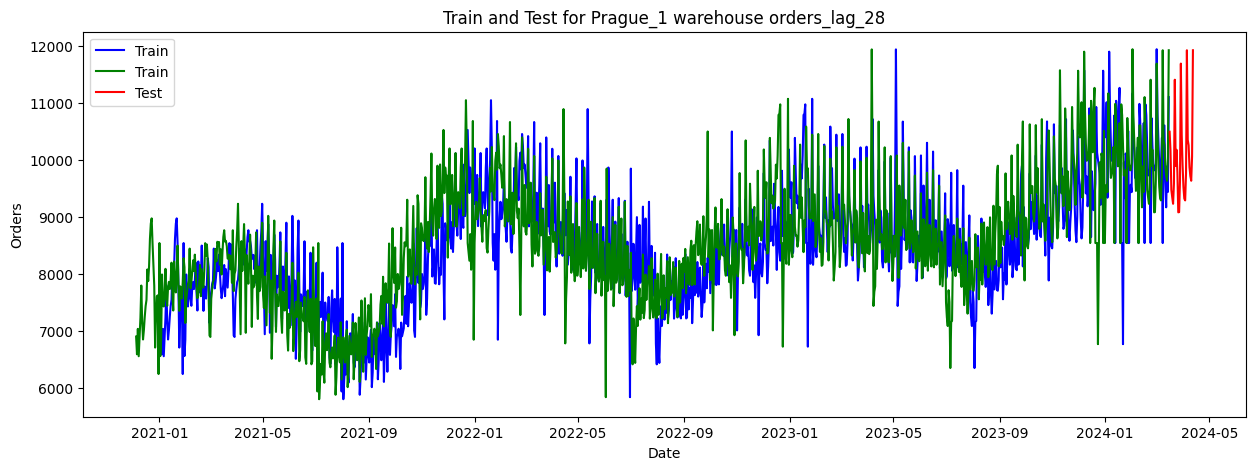

In [51]:
# plot the train and test datasets and visualise them in diferent colors for only column of prague_1 warehouse
feature = f'orders_lag_{LAG_DAYS[0]}'

plt.figure(figsize=(15, 5)) 
datax = train_df[train_df['warehouse_Prague_1'] == 1]
datax_test = test_df[test_df['warehouse'] == 'Prague_1']
plt.plot(datax.index, datax[feature], label='Train', color='blue')
plt.plot(datax.index, datax['orders'], label='Train', color='green')
plt.plot(datax_test.index, datax_test[feature], label='Test', color='red')


plt.title(f'Train and Test for Prague_1 warehouse {feature}')

plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.show()

### Min-Max scale numerical features

In [52]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (1193, 45)
Test data: (61, 29)


In [53]:
print(train_df.isna().sum())  # Check for Nas

warehouse                    0
orders                       0
holiday                      0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
quarter                      0
year                         0
month                        0
day                          0
day_of_week                  0
day_of_year                  0
is_weekend                   0
days_since_start             0
year_sin                     0
year_cos                     0
month_sin                    0
month_cos                    0
orders_lag_28               28
orders_lag_56               56
orders_lag_168             168
orders_lag_364             364
orders_rolling_mean_28       0
orders_rolling_std_28        1
orders_rolling_mean_168      0
orders_rolling_std_168       1
orders_rolling_mean_364      0
orders_rolling_std_364       1
day_of_week_0                0
day_of_week_1                0
day_of_week_2                0
day_of_week_3                0
day_of_w

In [54]:
# Save all scaler features into singe json scaler config file:
scaler_config = {
    'num_features': numerical_features,
    'cat_features': categorical_features,
    'time_features': time_features,
}

joblib.dump(scaler_config, 'scaler_config_mt.joblib')

['scaler_config_mt.joblib']

In [55]:
train_df = train_df.fillna(0)

In [56]:
print("Start Date:", train_df.index.min())
print("End Date:", train_df.index.max())        

Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00


In [57]:
"""drop nan values of these columns 
orders_lag_98                                                                
orders_lag_196                                                             
orders_lag_364                                                              
orders_rolling_mean_98                                                         
orders_rolling_std_98                                                          
orders_rolling_mean_364                                                        
orders_rolling_std_364     
"""
subset = []
for feature in numerical_features:
    if 'lag' in feature or 'rolling' in feature:
        subset.append(feature)
print(subset)
#train_df = train_df.dropna(subset=subset)
                     
print("Start Date:", train_df.index.min())
print("End Date:", train_df.index.max())                               

['orders_lag_28', 'orders_lag_56', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_28', 'orders_rolling_std_28', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00


In [58]:
train_df.head()

,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4,year_2020,year_2021,year_2022,year_2023,year_2024,warehouse_Prague_1
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,Prague_1,6895.0,0,0,0,0,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0,0.0,0.0,0.0,0.0,6895.000000,0.000000,6895.000000,0.000000,6895.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2020-12-06,Prague_1,6584.0,0,0,0,0,4,2020,12,6,6,341,1,1,-1.630940e-09,2020.0,-3.526983e-14,12.0,0.0,0.0,0.0,0.0,6739.500000,219.910209,6739.500000,219.910209,6739.500000,219.910209,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2020-12-07,Prague_1,7030.0,0,0,0,0,4,2020,12,7,0,342,0,2,-1.630940e-09,2020.0,-3.526983e-14,12.0,0.0,0.0,0.0,0.0,6836.333333,228.714524,6836.333333,228.714524,6836.333333,228.714524,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2020-12-08,Prague_1,6550.0,0,0,0,0,4,2020,12,8,1,343,0,3,-1.630940e-09,2020.0,-3.526983e-14,12.0,0.0,0.0,0.0,0.0,6764.750000,235.308840,6764.750000,235.308840,6764.750000,235.308840,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2020-12-09,Prague_1,6910.0,0,0,0,0,4,2020,12,9,2,344,0,4,-1.630940e-09,2020.0,-3.526983e-14,12.0,0.0,0.0,0.0,0.0,6793.800000,213.885951,6793.800000,213.885951,6793.800000,213.885951,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [59]:
train_df.describe()

,orders,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4,year_2020,year_2021,year_2022,year_2023,year_2024,warehouse_Prague_1
count,1193.000000,1193.000000,1193.000000,1193.000000,1193.0,1193.00000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1.193000e+03,1193.000000,1.193000e+03,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.0
mean,8513.161832,0.037720,0.016764,0.070411,0.0,2.44342,2022.082146,6.333613,15.633697,2.997485,177.140821,0.284996,598.102263,-1.327281e-09,2022.082146,-1.888112e-14,6.333613,8277.750264,8041.430337,7133.814498,5723.153978,8478.225131,615.586777,8343.840000,761.218896,8234.248407,830.414429,0.142498,0.143336,0.143336,0.143336,0.142498,0.142498,0.142498,0.289187,0.228835,0.231350,0.250629,0.021794,0.305113,0.305113,0.305113,0.062867,1.0
std,1066.885000,0.190598,0.128442,0.255945,0.0,1.15219,0.971036,3.593107,8.778163,1.999369,109.855917,0.451602,345.455564,9.840509e-10,0.971036,2.755058e-14,3.593107,1648.109646,2045.061783,3018.871721,3879.694101,856.555557,166.782197,645.030493,147.609749,481.677878,174.828043,0.349707,0.350562,0.350562,0.350562,0.349707,0.349707,0.349707,0.453575,0.420259,0.421872,0.433557,0.146071,0.460648,0.460648,0.460648,0.242825,0.0
min,5796.000000,0.000000,0.000000,0.000000,0.0,1.00000,2020.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-2.639248e-09,2020.000000,-1.077962e-13,1.000000,0.000000,0.000000,0.000000,0.000000,6541.142857,0.000000,6739.500000,0.000000,6739.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,7822.000000,0.000000,0.000000,0.000000,0.0,1.00000,2021.000000,3.000000,8.000000,1.000000,75.000000,0.000000,299.000000,-2.639248e-09,2021.000000,-2.449294e-14,3.000000,7748.000000,7676.000000,7213.000000,0.000000,7878.107143,523.770906,7842.686530,691.417347,7819.362667,735.803129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,8478.000000,0.000000,0.000000,0.000000,0.0,2.00000,2022.000000,6.000000,16.000000,3.000000,174.000000,0.000000,598.000000,-1.304240e-09,2022.000000,-8.817457e-15,6.000000,8426.000000,8372.000000,8132.000000,7688.000000,8523.464286,606.797669,8485.428571,753.115902,8375.015588,831.251845,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,9140.000000,0.000000,0.000000,0.000000,0.0,4.00000,2023.000000,10.000000,23.000000,5.000000,274.000000,1.000000,897.000000,-2.967562e-10,2023.000000,-2.204364e-15,10.000000,9044.000000,8974.000000,8764.000000,8548.000000,9086.500389,714.344174,8863.470238,807.691932,8561.405698,927.138520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.0
max,11935.000000,1.000000,1.000000,1.000000,0.0,4.00000,2024.000000,12.000000,31.000000,6.000000,366.000000,1.000000,1196.000000,3.208798e-11,2024.000000,-2.449294e-16,12.000000,11935.000000,11932.000000,11932.000000,11065.000000,10319.690606,1127.688865,9795.008153,1208.711469,9144.174

In [60]:
# check non-continuos date timeline
train_df.index.to_series().diff().value_counts()

date
1 days    1188
2 days       4
Name: count, dtype: int64

### Create Time Series 

In [61]:
X_train = train_df.drop(columns=['orders'])
y_train = train_df['orders']

In [62]:
X_train.shape, y_train.shape

((1193, 44), (1193,))

In [63]:
warehouse = X_train['warehouse']
X_train= X_train.drop(columns=categorical_features)

In [64]:
#Standard Scaler:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
x_scaler = StandardScaler()
y_scaler = StandardScaler()

# Fit the scaler on the numeriacal columns
X_train_scaled = pd.DataFrame(x_scaler.fit_transform(X_train), columns=X_train.columns)
#X_train_scaled = x_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

# Save the scaler
joblib.dump(x_scaler, 'x_scaler_mt.joblib')
joblib.dump(y_scaler, 'y_scaler_mt.joblib')


['y_scaler_mt.joblib']

In [65]:
warehouse = warehouse.reset_index(drop=True)

In [66]:
train_df_warehouse = pd.concat([X_train_scaled, warehouse], axis=1)

In [67]:
X_train_scaled.max()

holiday                    5.050853
shops_closed               7.658329
winter_school_holidays     3.633508
school_holidays            0.000000
month                      1.577677
day                        1.751249
day_of_year                1.719874
is_weekend                 1.583927
days_since_start           1.731477
year_sin                   1.381981
year_cos                   1.975888
month_sin                  0.676719
month_cos                  1.577677
orders_lag_28              2.219988
orders_lag_56              1.903219
orders_lag_168             1.590064
orders_lag_364             1.377450
orders_rolling_mean_28     2.150751
orders_rolling_std_28      3.071772
orders_rolling_mean_168    2.250710
orders_rolling_std_168     3.032864
orders_rolling_mean_364    1.889867
orders_rolling_std_364     1.869833
day_of_week_0              2.453089
day_of_week_1              2.444710
day_of_week_2              2.444710
day_of_week_3              2.444710
day_of_week_4              2

In [68]:
time_steps = 168

In [69]:
# Create sequences for each warehouse
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

sequences = []
targets = []

for warehouse in train_df_warehouse['warehouse'].unique():
    warehouse_data = X_train_scaled[train_df_warehouse['warehouse'] == warehouse]
    
    if len(warehouse_data) > time_steps:
        generator = TimeseriesGenerator(X_train_scaled.values, 
                                        y_train_scaled, 
                                        length=time_steps, 
                                        batch_size=1)
        
        for i in range(len(generator)):
            x, y = generator[i]
            sequences.append(x)
            targets.append(y)

X = np.array(sequences)
y = np.array(targets)

X.shape, y.shape

((1025, 1, 168, 40), (1025, 1, 1))

In [70]:
X = np.squeeze(X, axis=1)
y = np.squeeze(y, axis=1)


In [71]:
"""
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X, y = create_sequences(X_train_scaled, y_train_scaled, time_steps)

X.shape, y.shape
"""

'\ndef create_sequences(X, y, time_steps=30):\n    Xs, ys = [], []\n    for i in range(len(X) - time_steps):\n        Xs.append(X[i:(i + time_steps)])\n        ys.append(y[i + time_steps])\n    return np.array(Xs), np.array(ys)\n\nX, y = create_sequences(X_train_scaled, y_train_scaled, time_steps)\n\nX.shape, y.shape\n'

### Data Loading

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)  

### Compile and Fit the model

In [73]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization, Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

LR = 1e-3
checkpointing = ModelCheckpoint('best_model_lstm_ms.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

"""
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

"""

model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(units=16, return_sequences=False))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(units=1))

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=LR))

history = model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1, validation_data=(X_val, y_val), callbacks=[checkpointing])

Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 1.2567
Epoch 1: val_loss improved from inf to 2.35488, saving model to best_model_lstm_ms.h5
103/103 [==============================] - 10s 41ms/step - loss: 1.2567 - val_loss: 2.3549
Epoch 2/50
102/103 [============================>.] - ETA: 0s - loss: 0.8792
Epoch 2: val_loss did not improve from 2.35488
103/103 [==============================] - 3s 29ms/step - loss: 0.8820 - val_loss: 2.3596
Epoch 3/50
102/103 [============================>.] - ETA: 0s - loss: 0.7516
Epoch 3: val_loss did not improve from 2.35488
103/103 [==============================] - 3s 29ms/step - loss: 0.7523 - val_loss: 2.5700
Epoch 4/50
103/103 [==============================] - ETA: 0s - loss: 0.6624
Epoch 4: val_loss did not improve from 2.35488
103/103 [==============================] - 3s 29ms/step - loss: 0.6624 - val_loss: 2.3973
Epoch 5/50
102/103 [============================>.] - ETA: 0s - loss: 0.5975
Epoch 5: val_loss did not i

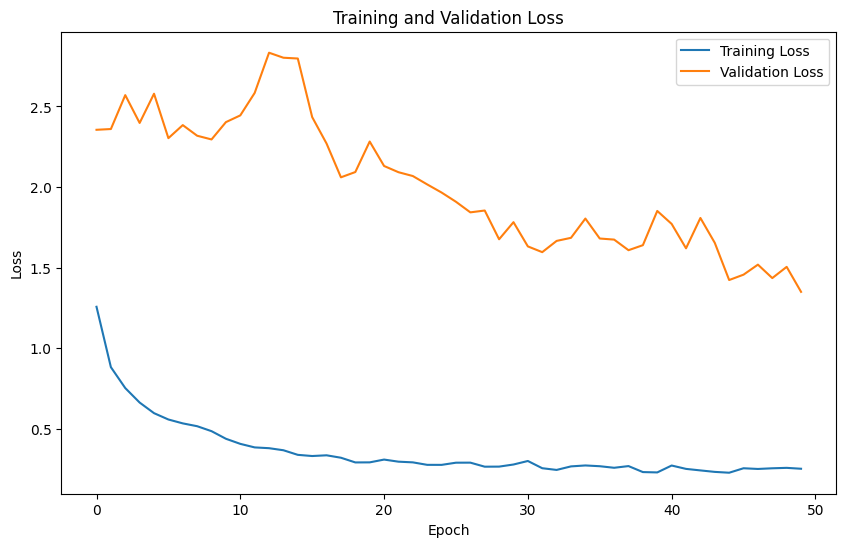

In [74]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Inference

#### MAPE

In [75]:
from sklearn.metrics import mean_absolute_percentage_error
# Evaluate the model on the validation set
model = tf.keras.models.load_model('best_model_lstm_ms.h5')

val_predictions = model.predict(X_val)
val_predictions = y_scaler.inverse_transform(val_predictions)
y_val_unscaled = y_scaler.inverse_transform(y_val)

mape = mean_absolute_percentage_error(y_val_unscaled, val_predictions) * 100
print(f'Tuned Model Mean Absolute Percentage Error: {mape:.4f}%')

7/7 [==============================] - 1s 31ms/step
Tuned Model Mean Absolute Percentage Error: 9.8500%


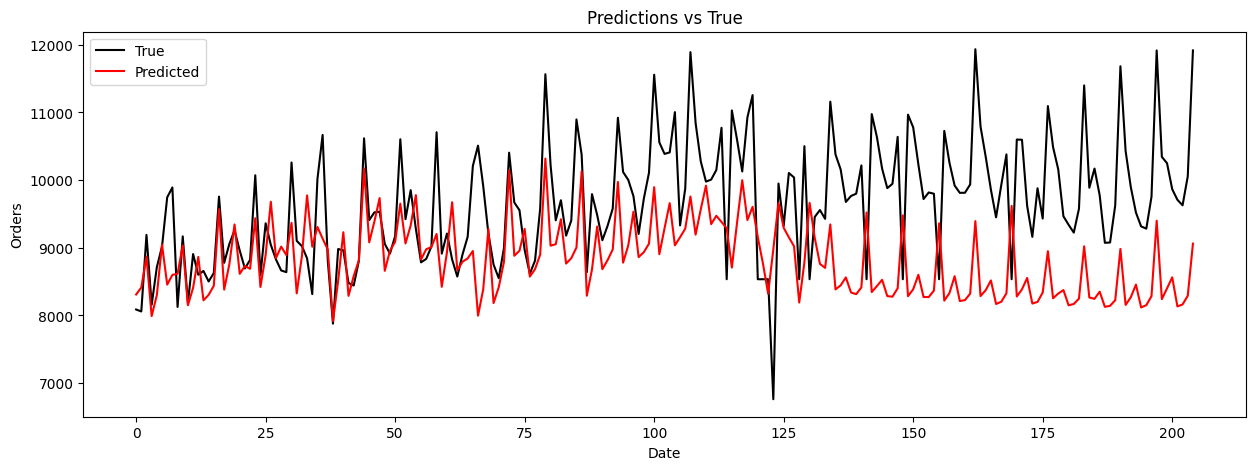

In [76]:
# Visualise the predictions in compare to the same dates in the training data in year 2023
plt.figure(figsize=(15, 5))
plt.plot(y_val_unscaled, label='True', color='black')
plt.plot(val_predictions, label='Predicted', color='red')
plt.title('Predictions vs True')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.show()


In [77]:
import pandas as pd
import joblib

dataframe = pd.read_csv("data/test_proc_mt.csv")

In [78]:
dataframe.head(10)

,date,warehouse,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364,date.1
0,2024-03-16,Prague_1,0,0,0,0,Prague_1_2024-03-16,1,2024,3,16,5,76,1,1197,3.208798e-11,2024.0,-2.204364e-15,3.0,10488.0,10968.000000,8806.0,9817.0,10013.259259,820.309960,9800.930357,857.918746,9142.320578,1001.939716,2024-03-16
1,2024-03-17,Prague_1,0,0,0,0,Prague_1_2024-03-17,1,2024,3,17,6,77,1,1198,3.208798e-11,2024.0,-2.204364e-15,3.0,10159.0,10780.000000,7879.0,8544.0,10007.653846,836.027796,9812.508251,847.327389,9143.973397,1002.830813,2024-03-17
2,2024-03-18,Prague_1,0,0,0,0,Prague_1_2024-03-18,1,2024,3,18,0,78,0,1199,3.208798e-11,2024.0,-2.204364e-15,3.0,9466.0,10232.000000,8982.0,9109.0,10029.320000,845.784583,9817.541634,847.413881,9144.070276,1004.220971,2024-03-18
3,2024-03-19,Prague_1,0,0,0,0,Prague_1_2024-03-19,1,2024,3,19,1,79,0,1200,3.208798e-11,2024.0,-2.204364e-15,3.0,9340.0,9721.000000,8962.0,8977.0,10058.041667,851.430432,9822.758352,847.347620,9144.534360,1005.579869,2024-03-19
4,2024-03-20,Prague_1,0,0,0,0,Prague_1_2024-03-20,1,2024,3,20,2,80,0,1201,3.208798e-11,2024.0,-2.204364e-15,3.0,9224.0,9818.000000,8480.0,8215.0,10094.304348,851.405439,9830.996133,843.345817,9147.123592,1005.780891,2024-03-20
5,2024-03-21,Prague_1,0,0,0,0,Prague_1_2024-03-21,1,2024,3,21,3,81,0,1202,3.208798e-11,2024.0,-2.204364e-15,3.0,9578.0,9799.000000,8442.0,8107.0,10117.772727,863.793402,9839.570183,838.804204,9150.028966,1005.678838,2024-03-21
6,2024-03-22,Prague_1,0,0,0,0,Prague_1_2024-03-22,1,2024,3,22,4,82,0,1203,3.208798e-11,2024.0,-2.204364e-15,3.0,11400.0,8535.336966,8809.0,8750.0,10056.714286,835.060545,9845.971240,837.442982,9151.149495,1006.866498,2024-03-22
7,2024-03-23,Prague_1,0,0,0,0,Prague_1_2024-03-23,1,2024,3,23,5,83,1,1204,3.208798e-11,2024.0,-2.204364e-15,3.0,9888.0,10728.000000,10618.0,9967.0,10065.150000,855.835527,9841.146060,837.824249,9148.857780,1007.350800,2024-03-23
8,2024-03-24,Prague_1,0,0,0,0,Prague_1_2024-03-24,1,2024,3,24,6,84,1,1205,3.208798e-11,2024.0,-2.204364e-15,3.0,10171.0,10258.000000,9410.0,8590.0,10059.578947,878.914755,9843.857671,839.766808,9150.432027,1008.333984,2024-03-24
9,2024-03-25,Prague_1,0,0,0,0,Prague_1_2024-03-25,1,2024,3,25,0,85,0,1206,3.208798e-11,2024.0,-2.204364e-15,3.0,9776.0,9920.000000,9524.0,8356.0,10075.333333,901.631071,9845.882086,842.047677,9152.676185,1008.873019,2024-03-25


In [79]:
import os
xsc = joblib.load(os.path.join("x_scaler_mt.joblib"))
ysc = joblib.load(os.path.join("y_scaler_mt.joblib"))
ohsc = joblib.load(os.path.join("scaler_onehot_categorical_mt.joblib"))

In [80]:
# load scaler config:
scaler_config = joblib.load('scaler_config_mt.joblib')

num_features = scaler_config['num_features']
cat_features = scaler_config['cat_features']
time_features = scaler_config['time_features']
    
print(f"num_features: {num_features}")
print(f"cat_features: {cat_features}")
print(f"time_features: {time_features}")

num_features: ['orders', 'orders_lag_28', 'orders_lag_56', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_28', 'orders_rolling_std_28', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']
cat_features: ['day_of_week', 'quarter', 'year', 'warehouse']
time_features: ['day', 'days_since_start', 'month', 'day_of_year', 'year_sin', 'year_cos', 'month_sin', 'month_cos']


In [81]:
from working import preprocess_data
id = dataframe.pop('id')
dataframe.drop(columns=['date.1'], inplace=True)
processed_data = preprocess_data(dataframe, xsc, ohsc, cat_features)

In [82]:
processed_data.head()     

,holiday,shops_closed,winter_school_holidays,school_holidays,month,day,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4,year_2020,year_2021,year_2022,year_2023,year_2024,warehouse_Prague_1
0,-0.197986,-0.130577,-0.275216,0.0,-0.928169,0.041746,-0.921054,1.583927,1.734373,1.381981,1.975888,0.605568,-0.928169,1.341644,1.431642,0.554143,1.055641,1.792853,1.228003,2.259895,0.655379,1.886018,0.981520,-0.407649,-0.409046,-0.409046,-0.409046,-0.407649,2.453089,-0.407649,1.567792,-0.544738,-0.548618,-0.578318,-0.149263,-0.662634,-0.662634,-0.662634,3.860915,0.0
1,-0.197986,-0.130577,-0.275216,0.0,-0.928169,0.155713,-0.911947,1.583927,1.737269,1.381981,1.975888,0.605568,-0.928169,1.141938,1.339675,0.246946,0.727384,1.786306,1.322284,2.277852,0.583597,1.889450,0.986619,-0.407649,-0.409046,-0.409046,-0.409046,-0.407649,-0.407649,2.453089,1.567792,-0.544738,-0.548618,-0.578318,-0.149263,-0.662634,-0.662634,-0.662634,3.860915,0.0
2,-0.197986,-0.130577,-0.275216,0.0,-0.928169,0.269680,-0.902841,-0.631342,1.740165,1.381981,1.975888,0.605568,-0.928169,0.721280,1.071600,0.612467,0.873076,1.811611,1.380809,2.285659,0.584183,1.889652,0.994574,2.453089,-0.409046,-0.409046,-0.409046,-0.407649,-0.407649,-0.407649,1.567792,-0.544738,-0.548618,-0.578318,-0.149263,-0.662634,-0.662634,-0.662634,3.860915,0.0
3,-0.197986,-0.130577,-0.275216,0.0,-0.928169,0.383647,-0.893734,-0.631342,1.743061,1.381981,1.975888,0.605568,-0.928169,0.644796,0.821625,0.605840,0.839038,1.845157,1.414675,2.293750,0.583734,1.890616,1.002350,-0.407649,2.444710,-0.409046,-0.409046,-0.407649,-0.407649,-0.407649,1.567792,-0.544738,-0.548618,-0.578318,-0.149263,-0.662634,-0.662634,-0.662634,3.860915,0.0
4,-0.197986,-0.130577,-0.275216,0.0,-0.928169,0.497614,-0.884627,-0.631342,1.745957,1.381981,1.975888,0.605568,-0.928169,0.574383,0.869076,0.446110,0.642548,1.887510,1.414525,2.306526,0.556612,1.895993,1.003500,-0.407649,-0.409046,2.444710,-0.409046,-0.407649,-0.407649,-0.407649,1.567792,-0.544738,-0.548618,-0.578318,-0.149263,-0.662634,-0.662634,-0.662634,3.860915,0.0


In [83]:
processed_data.shape

(61, 40)

In [84]:
# Compare the columns in the original and processed dataframes

X_columns = set(train_df.columns)
processed_data_columns = set(processed_data.columns)

if X_columns == processed_data_columns:
    print("this df has the same columns as the training df.")
else:
    print("The dataframes have different columns.")

    columns_only_in_X = X_columns - processed_data_columns
    columns_only_in_processed_data = processed_data_columns - X_columns

    if columns_only_in_X:
        print("Columns present only in train_df:")
        print(columns_only_in_X)

    if columns_only_in_processed_data:
        print("Columns present only in processed_data:")
        print(columns_only_in_processed_data)

The dataframes have different columns.
Columns present only in train_df:
{'warehouse', 'orders', 'quarter', 'year', 'day_of_week'}


In [85]:
processed_data = processed_data.fillna(0)

In [86]:
processed_data.head(10)

,holiday,shops_closed,winter_school_holidays,school_holidays,month,day,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4,year_2020,year_2021,year_2022,year_2023,year_2024,warehouse_Prague_1
0,-0.197986,-0.130577,-0.275216,0.0,-0.928169,0.041746,-0.921054,1.583927,1.734373,1.381981,1.975888,0.605568,-0.928169,1.341644,1.431642,0.554143,1.055641,1.792853,1.228003,2.259895,0.655379,1.886018,0.981520,-0.407649,-0.409046,-0.409046,-0.409046,-0.407649,2.453089,-0.407649,1.567792,-0.544738,-0.548618,-0.578318,-0.149263,-0.662634,-0.662634,-0.662634,3.860915,0.0
1,-0.197986,-0.130577,-0.275216,0.0,-0.928169,0.155713,-0.911947,1.583927,1.737269,1.381981,1.975888,0.605568,-0.928169,1.141938,1.339675,0.246946,0.727384,1.786306,1.322284,2.277852,0.583597,1.889450,0.986619,-0.407649,-0.409046,-0.409046,-0.409046,-0.407649,-0.407649,2.453089,1.567792,-0.544738,-0.548618,-0.578318,-0.149263,-0.662634,-0.662634,-0.662634,3.860915,0.0
2,-0.197986,-0.130577,-0.275216,0.0,-0.928169,0.269680,-0.902841,-0.631342,1.740165,1.381981,1.975888,0.605568,-0.928169,0.721280,1.071600,0.612467,0.873076,1.811611,1.380809,2.285659,0.584183,1.889652,0.994574,2.453089,-0.409046,-0.409046,-0.409046,-0.407649,-0.407649,-0.407649,1.567792,-0.544738,-0.548618,-0.578318,-0.149263,-0.662634,-0.662634,-0.662634,3.860915,0.0
3,-0.197986,-0.130577,-0.275216,0.0,-0.928169,0.383647,-0.893734,-0.631342,1.743061,1.381981,1.975888,0.605568,-0.928169,0.644796,0.821625,0.605840,0.839038,1.845157,1.414675,2.293750,0.583734,1.890616,1.002350,-0.407649,2.444710,-0.409046,-0.409046,-0.407649,-0.407649,-0.407649,1.567792,-0.544738,-0.548618,-0.578318,-0.149263,-0.662634,-0.662634,-0.662634,3.860915,0.0
4,-0.197986,-0.130577,-0.275216,0.0,-0.928169,0.497614,-0.884627,-0.631342,1.745957,1.381981,1.975888,0.605568,-0.928169,0.574383,0.869076,0.446110,0.642548,1.887510,1.414525,2.306526,0.556612,1.895993,1.003500,-0.407649,-0.409046,2.444710,-0.409046,-0.407649,-0.407649,-0.407649,1.567792,-0.544738,-0.548618,-0.578318,-0.149263,-0.662634,-0.662634,-0.662634,3.860915,0.0
5,-0.197986,-0.130577,-0.275216,0.0,-0.928169,0.611581,-0.875521,-0.631342,1.748853,1.381981,1.975888,0.605568,-0.928169,0.789265,0.859782,0.433518,0.614699,1.914920,1.488832,2.319824,0.525831,1.902028,1.002916,-0.407649,-0.409046,-0.409046,2.444710,-0.407649,-0.407649,-0.407649,1.567792,-0.544738,-0.548618,-0.578318,-0.149263,-0.662634,-0.662634,-0.662634,3.860915,0.0
6,-0.197986,-0.130577,-0.275216,0.0,-0.928169,0.725547,-0.866414,-0.631342,1.751749,1.381981,1.975888,0.605568,-0.928169,1.895237,0.241613,0.555137,0.780504,1.843606,1.316482,2.329752,0.516606,1.904355,1.009713,-0.407649,-0.409046,-0.409046,-0.409046,2.453089,-0.407649,-0.407649,1.567792,-0.544738,-0.548618,-0.578318,-0.149263,-0.662634,-0.662634,-0.662634,3.860915,0.0
7,-0.197986,-0.130577,-0.275216,0.0,-0.928169,0.839514,-0.857308,1.583927,1.754645,1.381981,1.975888,0.605568,-0.928169,0.977438,1.314237,1.154619,1.094320,1.853459,1.441098,2.322268,0.519190,1.899595,1.012484,-0.407649,-0.409046,-0.409046,-0.409046,-0.407649,2.453089,-0.407649,1.567792,-0.544738,-0.548618,-0.578318,-0.149263,-0.662634,-0.662634,-0.662634,3.860915,0.0
8,-0.197986,-0.130577,-0.275216,0.0,-0.928169,0.953481,-0.848201,1.583927,1.757541,1.381981,1.975888,0.605568,-0.928169,1.149222,1.084319,0.754302,0.739246,1.846952,1.579536,2.326474,0.532355,1.902865,1.018110,-0.407649,-0.409046,-0.409046,-0.409046,-0.407649,-0.407649,2.453089,1.567792,-0.544738,-0.548618,-0.578318,-0.149263,-0.662634,-0.662634,-0.662634,3.860915,0.0
9,-0.197986,-0.130577,-0.275216,0.0,-0.928169,1.067448,-0.839094,-0.631342,1.760437,1.381981,1.975888,0

In [87]:
processed_data.describe()

,holiday,shops_closed,winter_school_holidays,school_holidays,month,day,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4,year_2020,year_2021,year_2022,year_2023,year_2024,warehouse_Prague_1
count,61.000000,61.000000,61.000000,61.0,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,6.100000e+01,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,6.100000e+01,6.100000e+01,61.000000,6.100000e+01,61.000000,61.0
mean,0.318293,0.124797,-0.275216,0.0,-0.654306,0.013722,-0.647855,0.022344,1.821252,1.381981,1.975888e+00,0.539957,-0.654306,0.488285,0.901834,0.760468,0.803301,0.926864,0.753122,2.441069,0.574304,1.951750,1.033110,0.014427,0.012000,0.012000,-0.034783,-0.032470,0.014427,0.014427,-0.059313,1.211357,-0.548618,-0.578318,-1.492627e-01,-6.626336e-01,-0.662634,-6.626336e-01,3.860915,0.0
std,1.576085,1.398546,0.000000,0.0,0.200079,1.012030,0.161670,1.018724,0.051411,0.000000,2.238873e-16,0.051225,0.200079,0.628058,0.450533,0.240292,0.207564,1.090243,0.994741,0.092916,0.037144,0.040259,0.035821,1.022964,1.020468,1.020468,0.971313,0.973690,1.022964,1.022964,0.978270,1.055822,0.000000,0.000000,2.798592e-17,1.119437e-16,0.000000,1.119437e-16,0.000000,0.0
min,-0.197986,-0.130577,-0.275216,0.0,-0.928169,-1.667756,-0.921054,-0.631342,1.734373,1.381981,1.975888e+00,0.463266,-0.928169,0.000000,0.000000,0.246946,0.440644,0.000000,0.000000,2.259895,0.491732,1.886018,0.979194,-0.407649,-0.409046,-0.409046,-0.409046,-0.407649,-0.407649,-0.407649,-0.637840,-0.544738,-0.548618,-0.578318,-1.492627e-01,-6.626336e-01,-0.662634,-6.626336e-01,3.860915,0.0
25%,-0.197986,-0.130577,-0.275216,0.0,-0.928169,-0.869988,-0.784454,-0.631342,1.777812,1.381981,1.975888e+00,0.543311,-0.928169,0.000000,0.689055,0.589933,0.675039,0.000000,0.000000,2.353866,0.549300,1.919550,1.003500,-0.407649,-0.409046,-0.409046,-0.409046,-0.407649,-0.407649,-0.407649,-0.637840,-0.544738,-0.548618,-0.578318,-1.492627e-01,-6.626336e-01,-0.662634,-6.626336e-01,3.860915,0.0
50%,-0.197986,-0.130577,-0.275216,0.0,-0.649742,0.041746,-0.647855,-0.631342,1.821252,1.381981,1.975888e+00,0.543311,-0.649742,0.000000,0.889622,0.711221,0.758328,0.000000,0.000000,2.443523,0.576088,1.947576,1.032001,-0.407649,-0.409046,-0.409046,-0.409046,-0.407649,-0.407649,-0.407649,-0.637840,1.835746,-0.548618,-0.578318,-1.492627e-01,-6.626336e-01,-0.662634,-6.626336e-01,3.860915,0.0
75%,-0.197986,-0.130577,-0.275216,0.0,-0.649742,0.839514,-0.511255,1.583927,1.864691,1.381981,1.975888e+00,0.605568,-0.649742,0.896099,1.126389,0.881223,0.873076,1.929298,1.471207,2.526148,0.593229,1.989633,1.052736,-0.407649,-0.409046,-0.409046,-0.409046,-0.407649,-0.407649,-0.407649,1.567792,1.835746,-0.548618,-0.578318,-1.492627e-01,-6.626336e-01,-0.662634,-6.626336e-01,3.860915,0.0
max,5.050853,7.658329,-0.275216,0.0,-0.371314,1.751249,-0.374655,1.583927,1.908130,1.381981,1.975888e+00,0.605568,-0.371314,2.209062,1.904687,1.468775,1.601015,4.016338,4.200884,2.574681,0.682917,2.017717,1.121270,2.453089,2.444710,2.444710,2.444710,2.453089,2.453089,2.453089,1.567792,1.835746,-0.548618,-0.578318,-1.492627e-01,-6.626336e-01,-0.662634,-6.626336e-01,3.860915,0.0


In [88]:
test_columns = processed_data.columns
time_steps = 1

In [102]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import pandas as pd

def pad_and_predict(model, data, time_steps, feature_columns):
    padded_data = data[feature_columns].copy()
    
    # Pad the beginning with the first row
    padding = pd.DataFrame([padded_data.iloc[0]] * (time_steps - 1), columns=padded_data.columns)
    padded_data = pd.concat([padding, padded_data]).reset_index(drop=True)
    
    dummy_targets = np.zeros(len(padded_data))
    
    generator = TimeseriesGenerator(padded_data.values, dummy_targets,
                                    length=time_steps, batch_size=1)
    
    predictions = model.predict(generator)
    
    return predictions[:len(data)]  # Return only predictions for actual data points


predictions = pad_and_predict(model, processed_data, time_steps, test_columns)

submission_df = pd.DataFrame({'id': id[:len(predictions)], 'orders': predictions.flatten()})
submission_df.to_csv('submission_padded_generator.csv', index=False)

19/60 [========>.....................] - ETA: 0s

C:\Users\ondre\AppData\Local\Temp\ipykernel_5756\1367973109.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  padded_data = pd.concat([padding, padded_data]).reset_index(drop=True)


60/60 [==============================] - 0s 6ms/step


In [90]:
import numpy as np
import pandas as pd

def variable_length_predict(model, data, max_time_steps, feature_columns):
    predictions = []
    for i in range(len(data)):
        seq_len = min(max_time_steps, i+1)
        sequence = data[feature_columns].iloc[max(0, i-seq_len+1):i+1]
        
        if len(sequence) < max_time_steps:
            padding = pd.DataFrame([sequence.iloc[0]] * (max_time_steps - len(sequence)), 
                                   columns=sequence.columns)
            sequence = pd.concat([padding, sequence]).reset_index(drop=True)
        
        # Reshape the sequence for the model
        model_input = sequence.values.reshape(1, max_time_steps, -1)
        
        # Make prediction
        pred = model.predict(model_input)
        predictions.append(pred[0][0])
    
    return np.array(predictions)

predictions = variable_length_predict(model, processed_data, time_steps, test_columns)

predictions = predictions.reshape(-1, 1)

submission_df = pd.DataFrame({'id': id[:len(predictions)], 'orders': predictions.flatten()})
submission_df.to_csv('submission_variable_length.csv', index=False)



1/1 [==============================] - 0s 23ms/step


In [91]:
import numpy as np
import pandas as pd

def rolling_forecast(model, data, time_steps, feature_columns, target_column='orders'):
    predictions = []
    current_data = data.copy()
    
    for i in range(len(data)):
        if i < time_steps - 1:
            sequence = np.tile(current_data[feature_columns].iloc[0].values, (time_steps, 1))
            sequence[-(i+1):] = current_data[feature_columns].iloc[:i+1].values
        else:
            sequence = current_data[feature_columns].iloc[i-time_steps+1:i+1].values
        
        model_input = sequence.reshape(1, time_steps, -1)
        
        # Make prediction
        pred = model.predict(model_input)[0][0]
        
        # Check for NaN prediction
        if np.isnan(pred):
            print(f"NaN prediction at step {i}")
            print("Input sequence:")
            print(sequence)
            # Use the last non-NaN prediction or 0 if it's the first prediction
            pred = predictions[-1] if predictions else 0
        
        predictions.append(pred)
        
        # Print every 100th prediction for monitoring
        if i % 100 == 0:
            print(f"Step {i}, Prediction: {pred}")
            print("Input features:")
            print(current_data[feature_columns].iloc[i])
            print("\n")
        
        # Update the data for the next prediction
        if i + 1 < len(data):
            current_data.loc[current_data.index[i+1], target_column] = pred
            
            for lag in [28, 56, 168, 364]:
                if i + 1 - lag >= 0:
                    current_data.loc[current_data.index[i+1], f'orders_lag_{lag}'] = current_data.loc[current_data.index[i+1-lag], target_column]
            
            window = min(28, i + 2)
            current_data.loc[current_data.index[i+1], 'orders_rolling_mean_28'] = current_data[target_column].iloc[max(0, i+2-window):i+2].mean()
            current_data.loc[current_data.index[i+1], 'orders_rolling_std_28'] = current_data[target_column].iloc[max(0, i+2-window):i+2].std()
            
            for col in feature_columns:
                if 'rolling_mean' in col or 'rolling_std' in col:
                    window_size = int(col.split('_')[-1])
                    if 'mean' in col:
                        current_data.loc[current_data.index[i+1], col] = current_data[target_column].iloc[max(0, i+2-window_size):i+2].mean()
                    elif 'std' in col:
                        current_data.loc[current_data.index[i+1], col] = current_data[target_column].iloc[max(0, i+2-window_size):i+2].std()
    
    return np.array(predictions)

# Usage
predictions = rolling_forecast(model, processed_data, time_steps, test_columns)

# Reshape predictions for inverse transform
predictions = predictions.reshape(-1, 1)

# Create submission DataFrame
submission_df = pd.DataFrame({'id': id[:len(predictions)], 'orders': predictions.flatten()})
submission_df.to_csv('submission_rolling_forecast.csv', index=False)

# Print first few predictions to verify
print("First few predictions:")
print(predictions[:10])

1/1 [==============================] - 0s 27ms/step
Step 0, Prediction: 0.24403224885463715
Input features:
holiday                   -0.197986
shops_closed              -0.130577
winter_school_holidays    -0.275216
school_holidays            0.000000
month                     -0.928169
day                        0.041746
day_of_year               -0.921054
is_weekend                 1.583927
days_since_start           1.734373
year_sin                   1.381981
year_cos                   1.975888
month_sin                  0.605568
month_cos                 -0.928169
orders_lag_28              1.341644
orders_lag_56              1.431642
orders_lag_168             0.554143
orders_lag_364             1.055641
orders_rolling_mean_28     1.792853
orders_rolling_std_28      1.228003
orders_rolling_mean_168    2.259895
orders_rolling_std_168     0.655379
orders_rolling_mean_364    1.886018
orders_rolling_std_364     0.981520
day_of_week_0             -0.407649
day_of_week_1             -0

In [92]:
# Create sequences for each warehouse
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

sequences = []

dummy_targets = np.zeros(len(processed_data)) 

    
if len(warehouse_data) > time_steps:
    generator = TimeseriesGenerator(processed_data, 
                                    dummy_targets, 
                                    length=time_steps, 
                                    batch_size=1)
    
    for i in range(len(generator)):
        x, y = generator[i]
        sequences.append(x)
        targets.append(y)

X = np.array(sequences)

X.shape

(60, 1, 1, 40)

In [93]:
X = np.squeeze(X, axis=1)

In [94]:
import tensorflow as tf
model = tf.keras.models.load_model('best_model_lstm_ms.h5')

In [95]:
predictions = model.predict(X_infer)

NameError: name 'X_infer' is not defined

In [ ]:
predictions.shape  

(60, 1)

In [103]:
# Rescale the predictions to original scale:
predictions_rescaled = ysc.inverse_transform(predictions)

#put the predictions into the dataframe with "id" and "orders" columns
submission_df = pd.DataFrame({'id': id[:len(predictions)], 'orders': predictions_rescaled.flatten()})

submission_df.to_csv('submission_rescaled_mt.csv', index=False)
submission_df.head()

,id,orders
0,Prague_1_2024-03-16,8773.407227
1,Prague_1_2024-03-17,8744.103516
2,Prague_1_2024-03-18,8486.674805
3,Prague_1_2024-03-19,8742.830078
4,Prague_1_2024-03-20,9041.574219


In [104]:
# Add the date column as an index and warehouse column to the rescaled predictions 
submission_df['date'] = dataframe['date']
submission_df['warehouse'] = dataframe['warehouse']
submission_df.tail(10)

,id,orders,date,warehouse
50,Prague_1_2024-05-05,8718.336914,2024-05-05,Prague_1
51,Prague_1_2024-05-06,8365.736328,2024-05-06,Prague_1
52,Prague_1_2024-05-07,8663.496094,2024-05-07,Prague_1
53,Prague_1_2024-05-08,8583.886719,2024-05-08,Prague_1
54,Prague_1_2024-05-09,9248.099609,2024-05-09,Prague_1
55,Prague_1_2024-05-10,8313.036133,2024-05-10,Prague_1
56,Prague_1_2024-05-11,8714.482422,2024-05-11,Prague_1
57,Prague_1_2024-05-12,8705.116211,2024-05-12,Prague_1
58,Prague_1_2024-05-13,8369.861328,2024-05-13,Prague_1
59,Prague_1_2024-05-14,8652.922852,2024-05-14,Prague_1


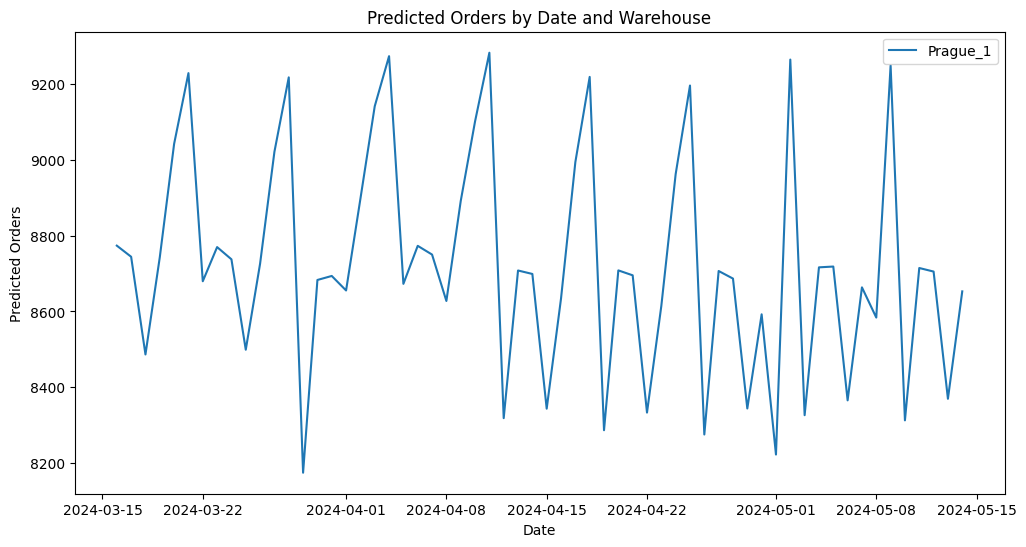

In [105]:
import matplotlib.pyplot as plt
# Visualise rescaled predictions with date for every warehouse on the same plot
warehouses = submission_df['warehouse'].unique()
plt.figure(figsize=(12, 6))
for wh in warehouses:
    wh_df = submission_df[submission_df['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label=wh)
    
plt.title('Predicted Orders by Date and Warehouse')
plt.xlabel('Date')
plt.ylabel('Predicted Orders')
plt.legend()

plt.show()

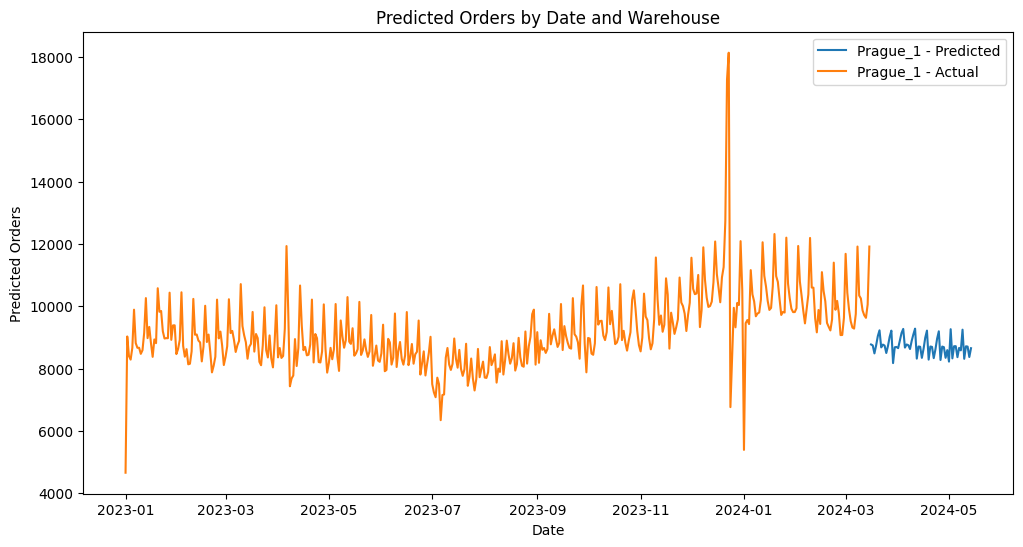

In [106]:
# Visualise the predictions in compare to the same dates in the training data in year 2023
train_df_2023 = train_df_raw[train_df_raw['date'].dt.year > 2022]
plt.figure(figsize=(12, 6))
for wh in warehouses:
    wh_df = submission_df[submission_df['warehouse'] == wh]
    wh_df_train = train_df_2023[train_df_2023['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label=f'{wh} - Predicted')
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label=f'{wh} - Actual')
    
plt.title('Predicted Orders by Date and Warehouse')
plt.xlabel('Date')
plt.ylabel('Predicted Orders')
plt.legend()

plt.show()


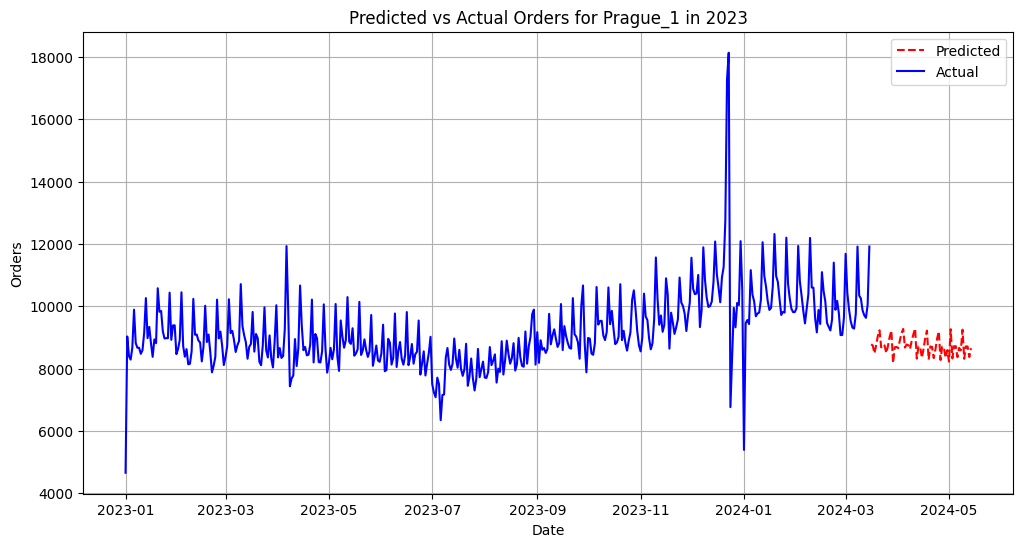

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming these dataframes are already loaded
# train_df_raw: Raw training data
# submission_df_rescaled: Rescaled predictions
# warehouses: List of warehouse names

# Filter training data for the year 2023
train_df_2023 = train_df_raw[train_df_raw['date'].dt.year > 2022]

# Create separate plots for each warehouse
for wh in warehouses:
    wh_df = submission_df[submission_df['warehouse'] == wh]
    wh_df_train = train_df_2023[train_df_2023['warehouse'] == wh]
    
    plt.figure(figsize=(12, 6))
    plt.plot(wh_df['date'], wh_df['orders'], label='Predicted', linestyle='--', color='r')
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label='Actual', color='b')
    plt.title(f'Predicted vs Actual Orders for {wh} in 2023')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.grid(True)
    plt.show()
